# 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb


#from scipy                  import stats as ss
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image


from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso

warnings.filterwarnings("ignore")

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat) / y))
   

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat) )
    
    return pd.DataFrame ( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])


def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list =[]
    mape_list =[]
    rmse_list = []

    for k in reversed( range( 1, kfold+1) ):
        if verbose:
            print('\nKFold Number: {}'.format( k ))

        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dateset
        #training
        xtraining = training.drop( ['date', 'sales'], axis = 1 )
        ytraining = training ['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation )

        #performace
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1( yhat) )

        #store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list), 2 ).astype( str ) + '+/-' + np.round( np.std( mae_list), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2 ).astype( str ) + '+/-' + np.round( np.std( mape_list), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2 ).astype( str ) + '+/-' + np.round( np.std( rmse_list), 2 ).astype( str ) } , index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv')
df_store_raw = pd.read_csv('data/store.csv')

#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
           'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new


In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}'.format( df1.shape[0]))
print('Number of Cols: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout Na

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis =1 )
                            
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis =1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis =1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1['promo_interval'].fillna( 0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [15]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## 1.6 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes( include=['int32','int64','float32','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int32','int64', 'float32', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [19]:
#Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

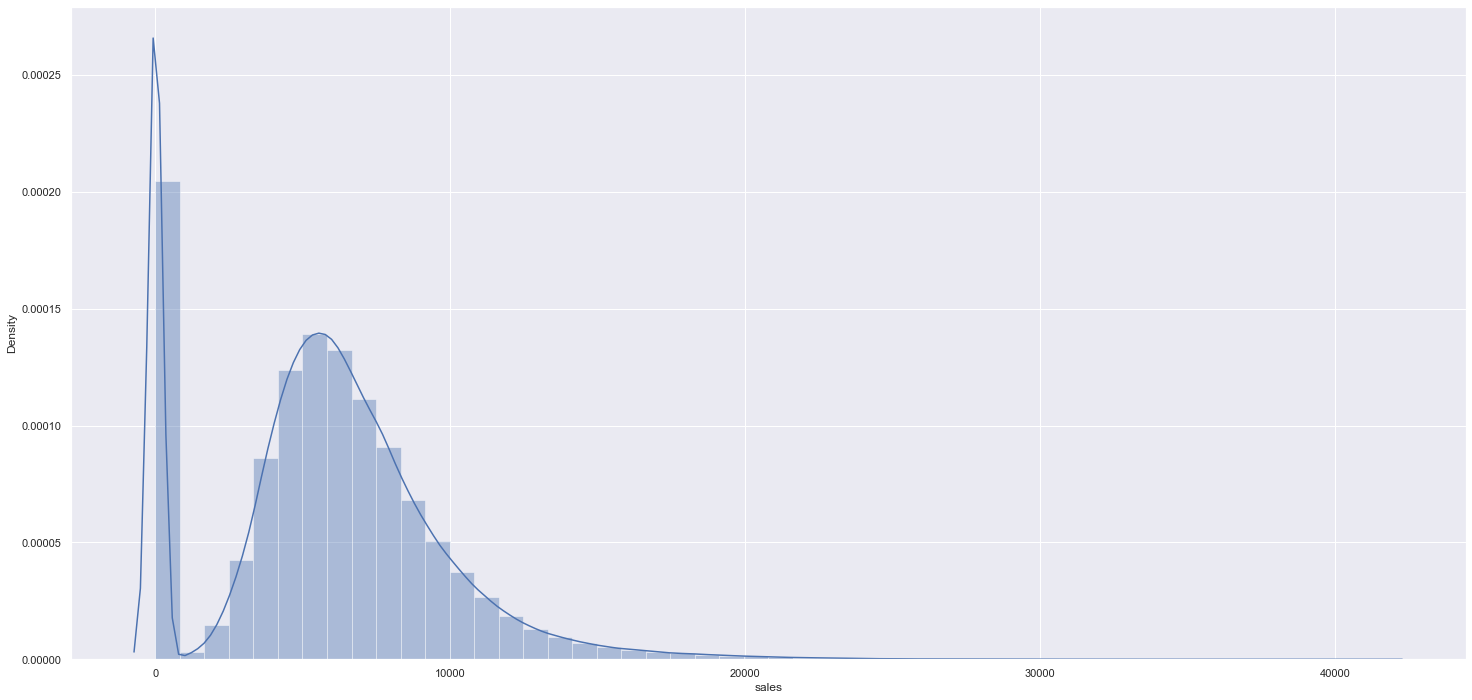

In [25]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [22]:
cat_attributes['state_holiday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64

In [23]:
df1['state_holiday'] = df1['state_holiday'].replace(0,str(0))

<AxesSubplot:xlabel='assortment', ylabel='sales'>

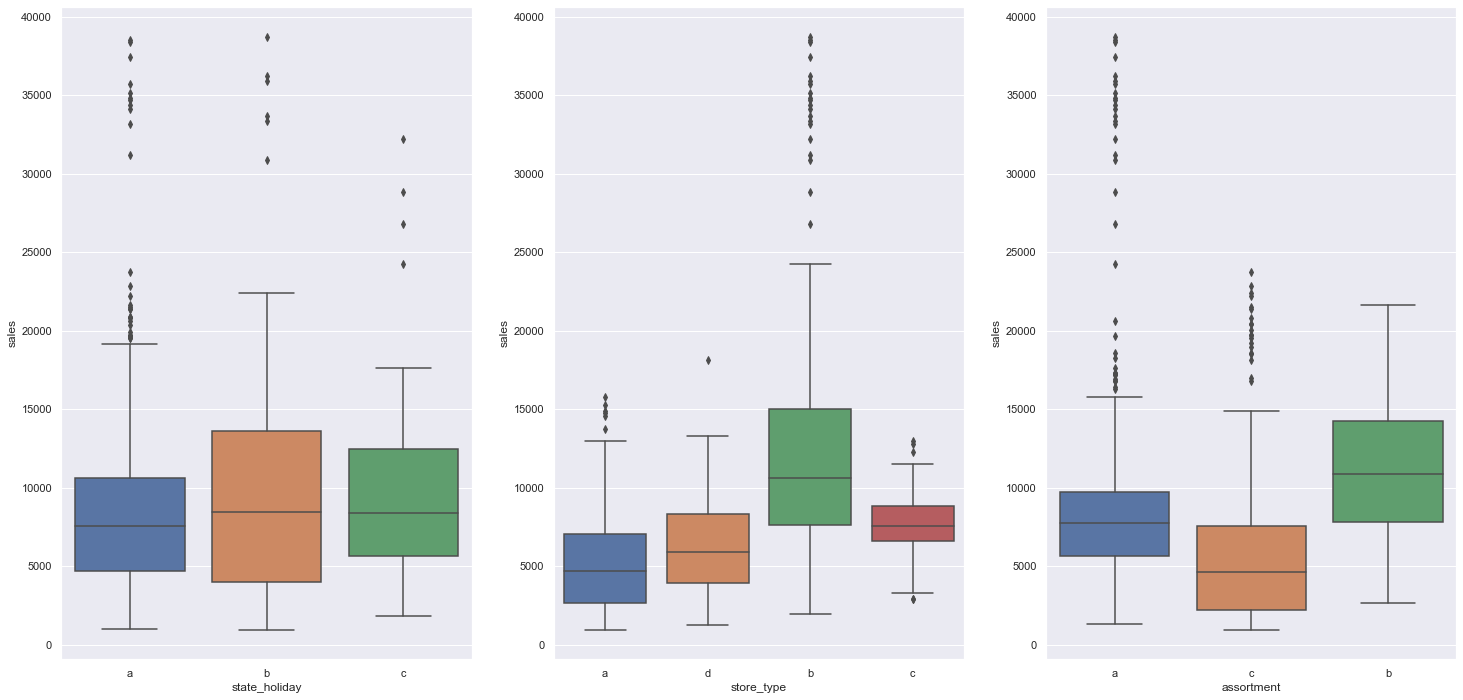

In [26]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1, 3, 1)
sns.boxplot(aux1['state_holiday'],aux1['sales'])

plt.subplot(1, 3, 2)
sns.boxplot(aux1['store_type'],aux1['sales'])

plt.subplot(1, 3, 3)
sns.boxplot(aux1['assortment'],aux1['sales'])


# 2.0 FEATURE ENGINEERING


## 2.1 Mapa Mental de Hipoteses

In [27]:
df2 = df1.copy()

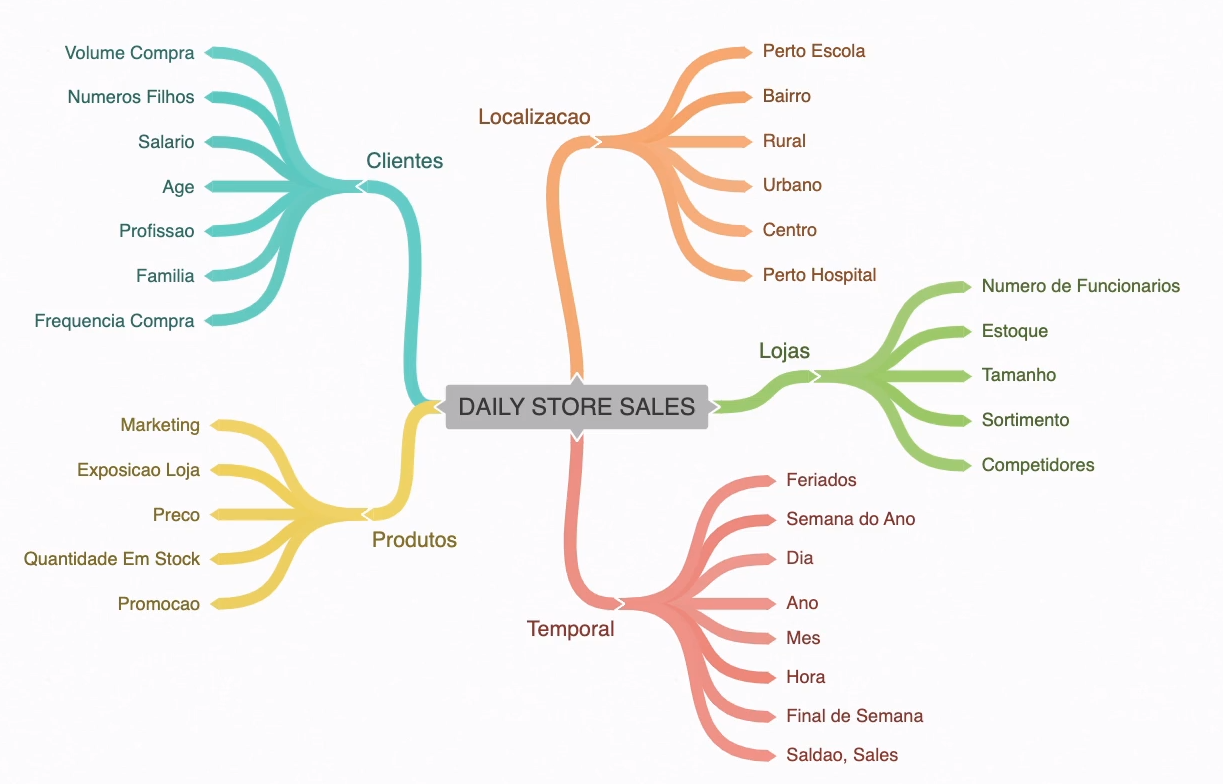

In [28]:
Image( 'img/MindMapHypothesis.png')

## 2.1 Criacao das Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionarios deveriam vender mais.

**2.** Lojas com maior  capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com cpmpetidores a mais tempo deveriam vender mais.


### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivais(descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com promoções consecutivas deveriam vender mais.




### 2.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender maenos aos finais de semana.

**6.** Lojas deveriam vender maenos durante os feriados escolares.




## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com cpmpetidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender maenos aos finais de semana.

**12.** Lojas deveriam vender maenos durante os feriados escolares.

## 2.3 Feature Engineering



In [29]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))

df2 ['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended' )

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x== 'a' else 'esater_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy() 
 
    

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [33]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [36]:
df4 = df3.copy()

In [37]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1. Analise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

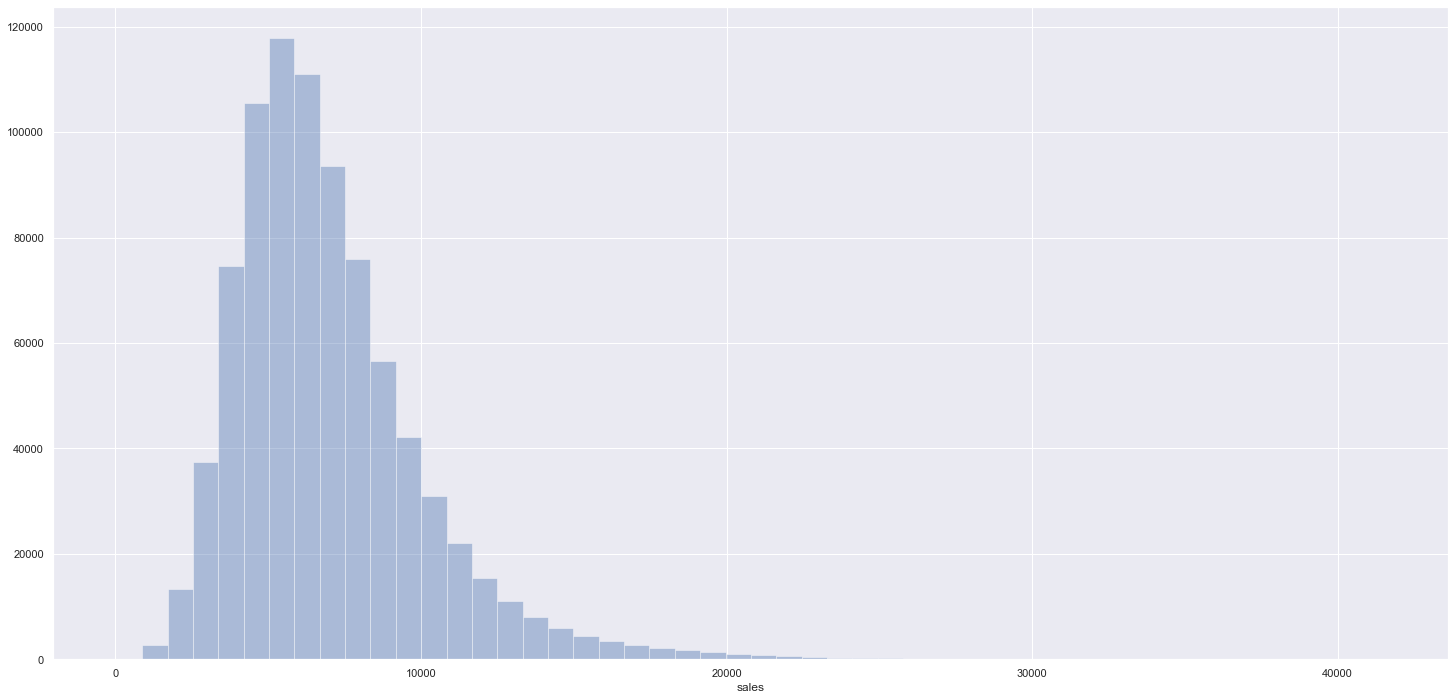

In [38]:
sns.distplot(df4['sales'], kde= False)

### 4.1.2 Numerical Variable

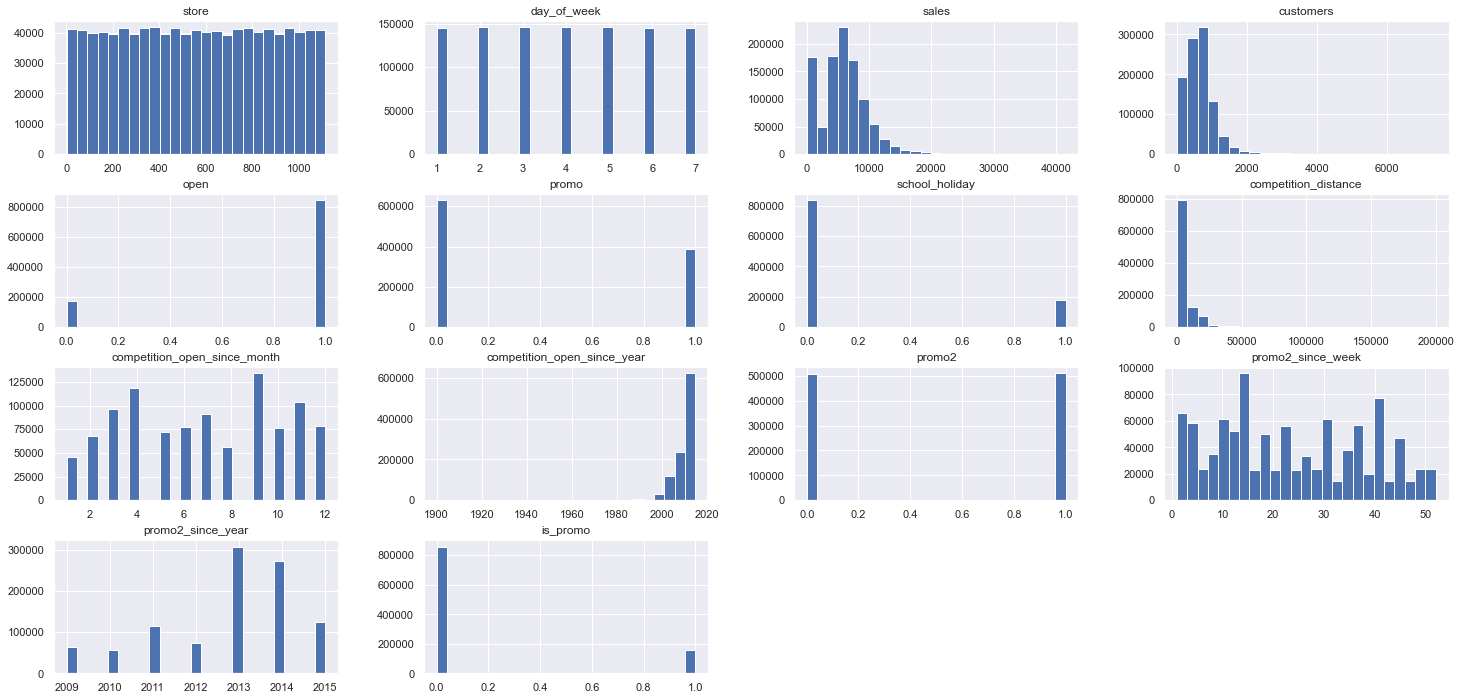

In [38]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

In [39]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    esater_holiday
241126         christmas
Name: state_holiday, dtype: object

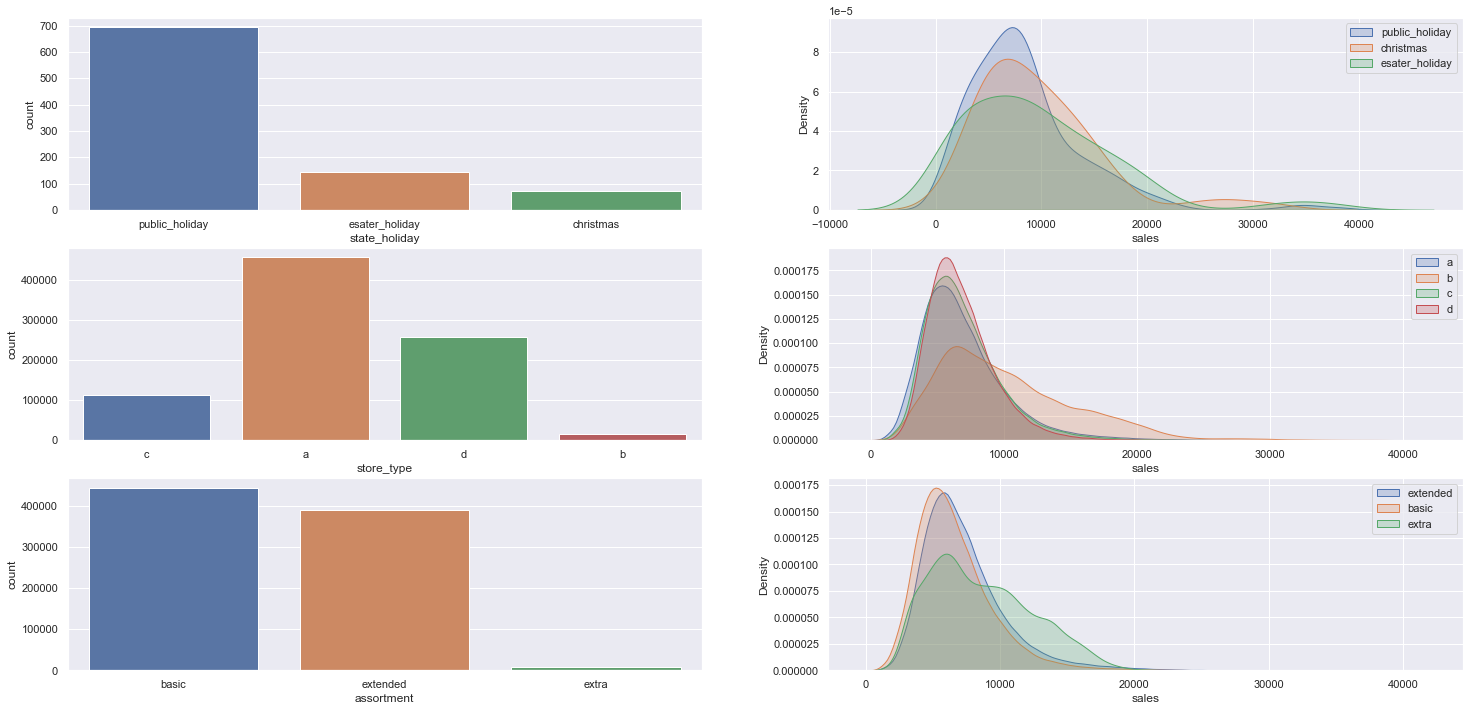

In [41]:
#state_holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'esater_holiday']['sales'], label = 'esater_holiday', shade = True)
plt.legend( )
#store_type

plt.subplot(3,2,3)
sns.countplot( df4['store_type'] )

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)
plt.legend( )

#assortment

plt.subplot(3,2,5)
sns.countplot( df4['assortment'] )

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
plt.legend( )


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
***VERDADEIRA*** na média elas vendem mais porem existem menos lojas com assortment extra

In [42]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

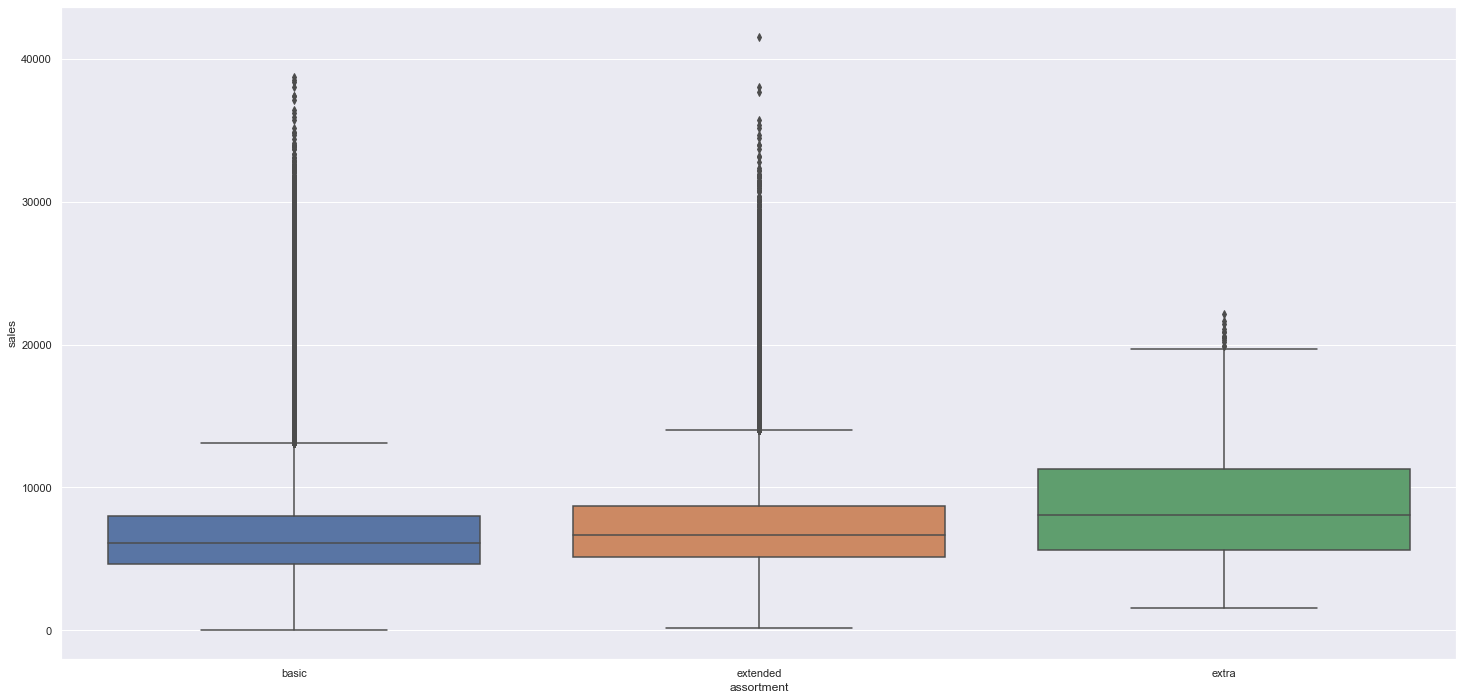

In [43]:
sns.boxplot(df4['assortment'], df4['sales'])

<AxesSubplot:xlabel='year_week'>

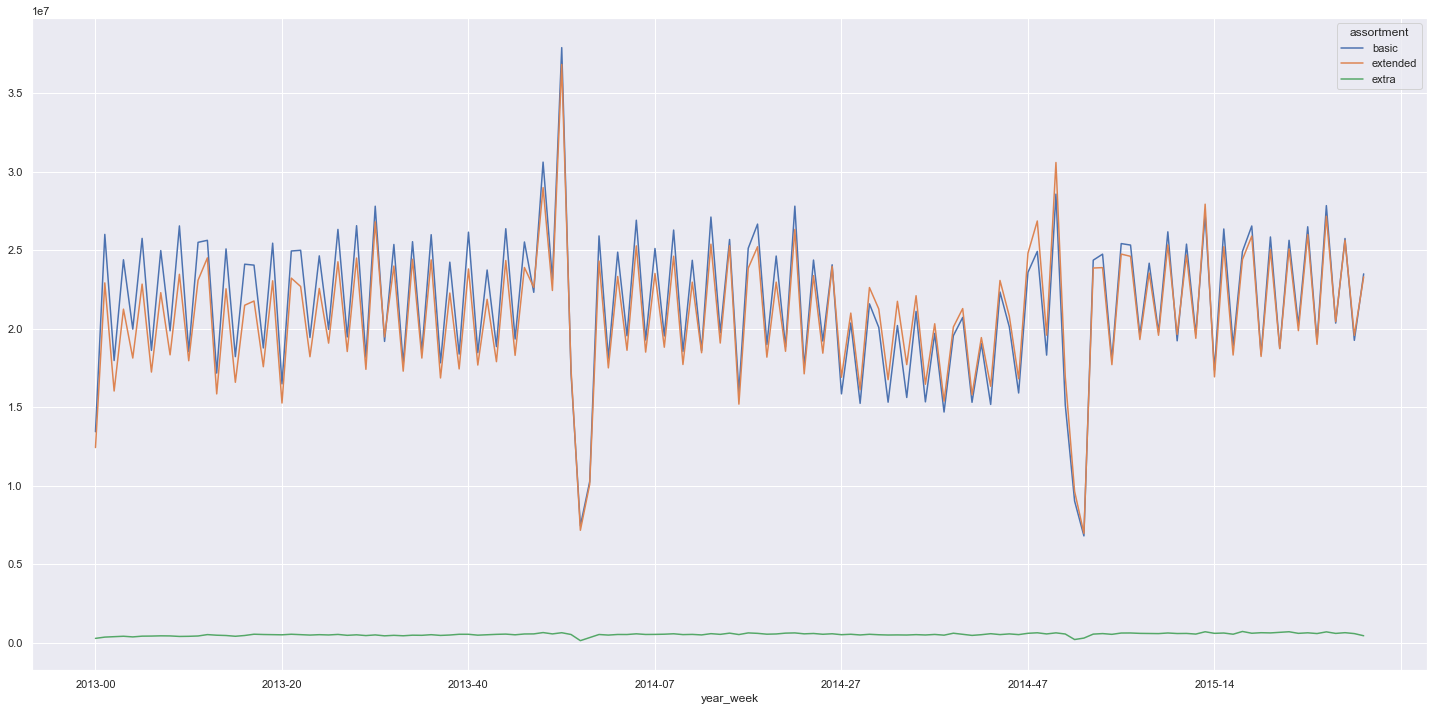

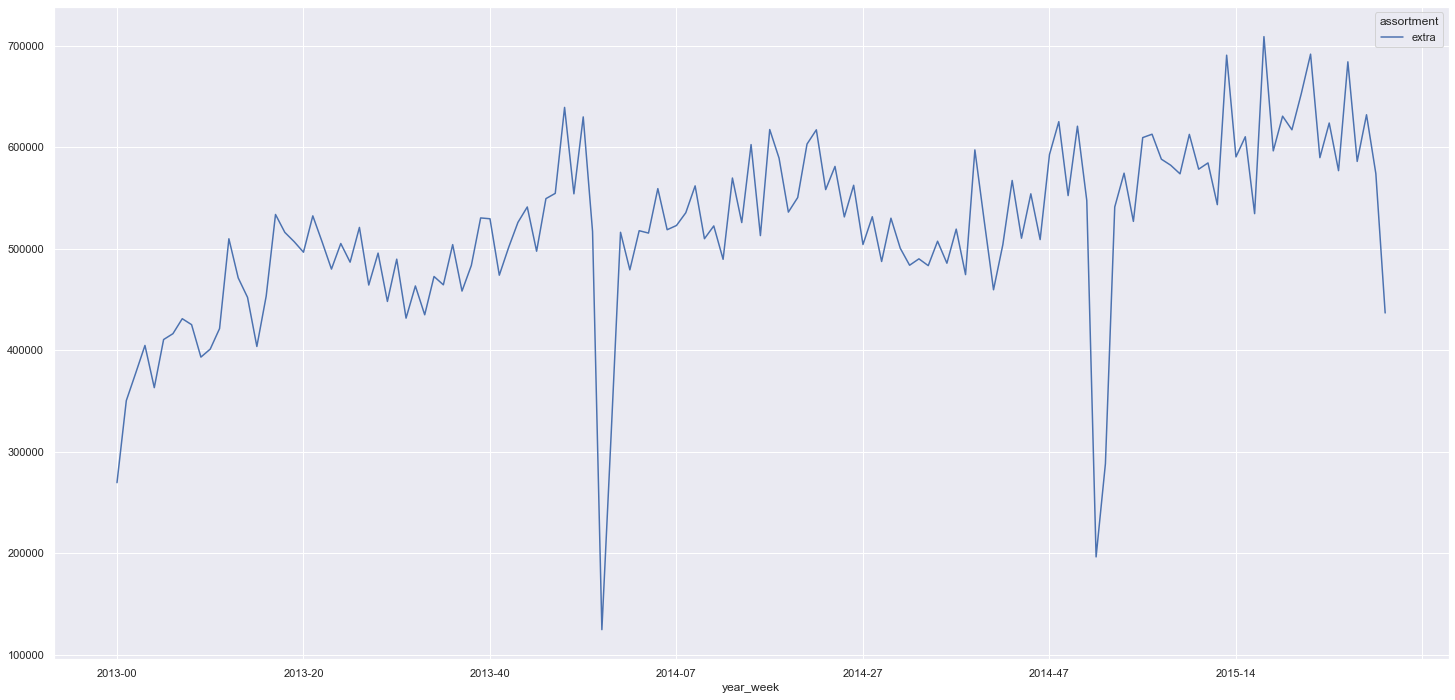

In [44]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


### H2. Lojas com competidores mais próximos deveriam vender menos

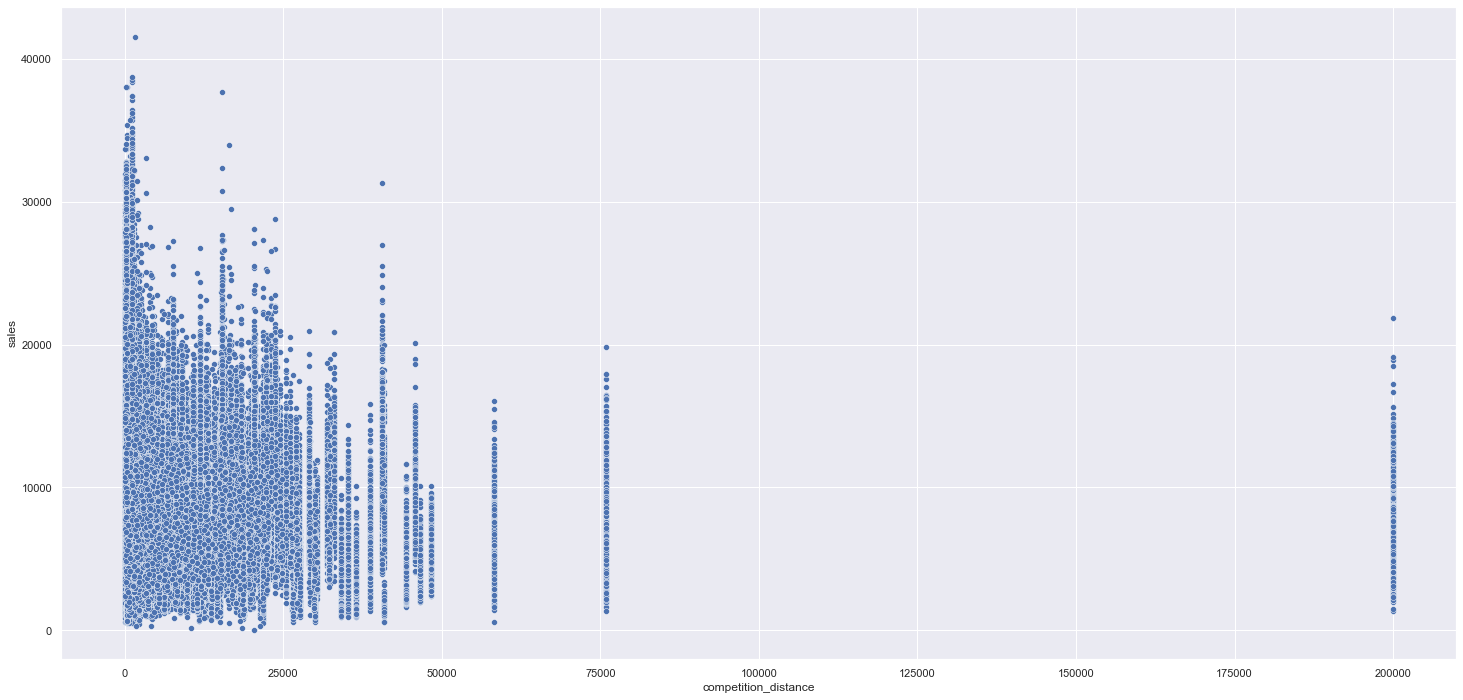

In [45]:
sns.scatterplot(df4['competition_distance'], df4['sales']);

<AxesSubplot:>

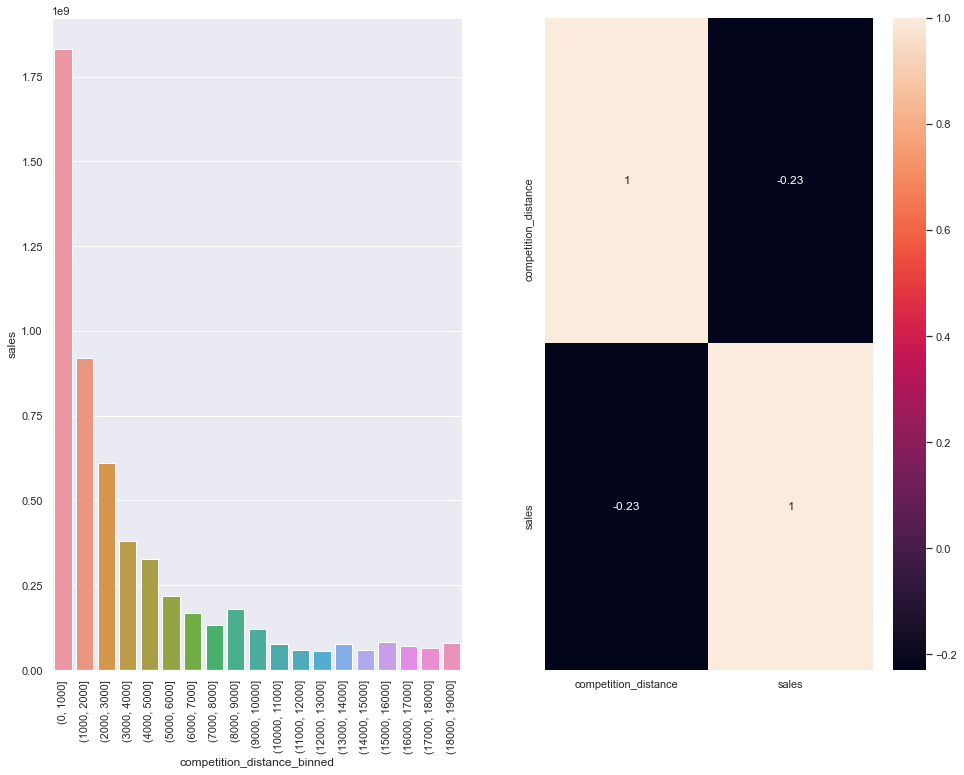

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()


sns.scatterplot( x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method = 'pearson'), annot= True)


In [139]:
aux1['competition_distance_binned'].value_counts()

(0, 1000]         93
(1000, 2000]      83
(2000, 3000]      68
(3000, 4000]      58
(4000, 5000]      43
(5000, 6000]      39
(8000, 9000]      29
(6000, 7000]      29
(7000, 8000]      22
(9000, 10000]     20
(10000, 11000]    14
(18000, 19000]    14
(13000, 14000]    13
(15000, 16000]    13
(16000, 17000]    12
(17000, 18000]    11
(11000, 12000]    11
(12000, 13000]    10
(14000, 15000]     9
Name: competition_distance_binned, dtype: int64

<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

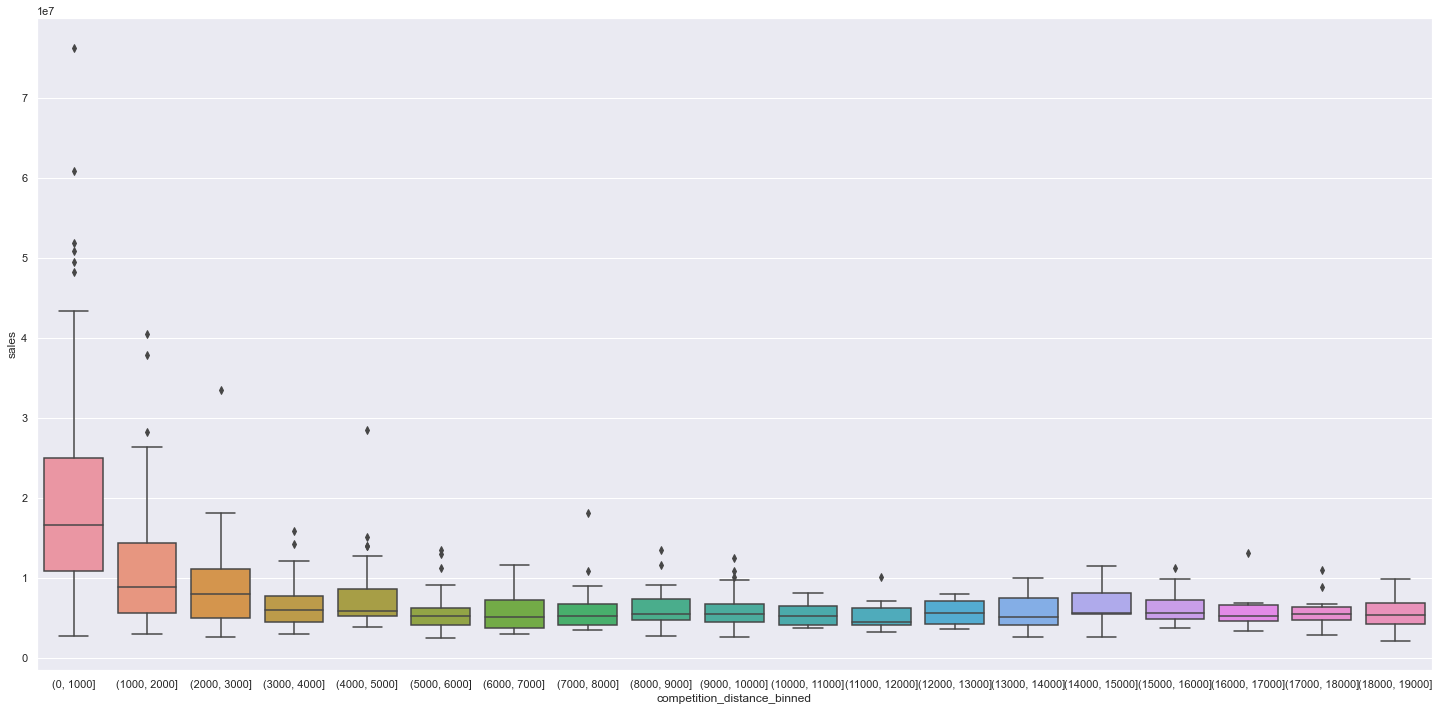

In [52]:
sns.boxplot( x= 'competition_distance_binned', y='sales', data=aux1)

### H3. Lojas com competidores a mais tempo deveriam vender mais

<AxesSubplot:>

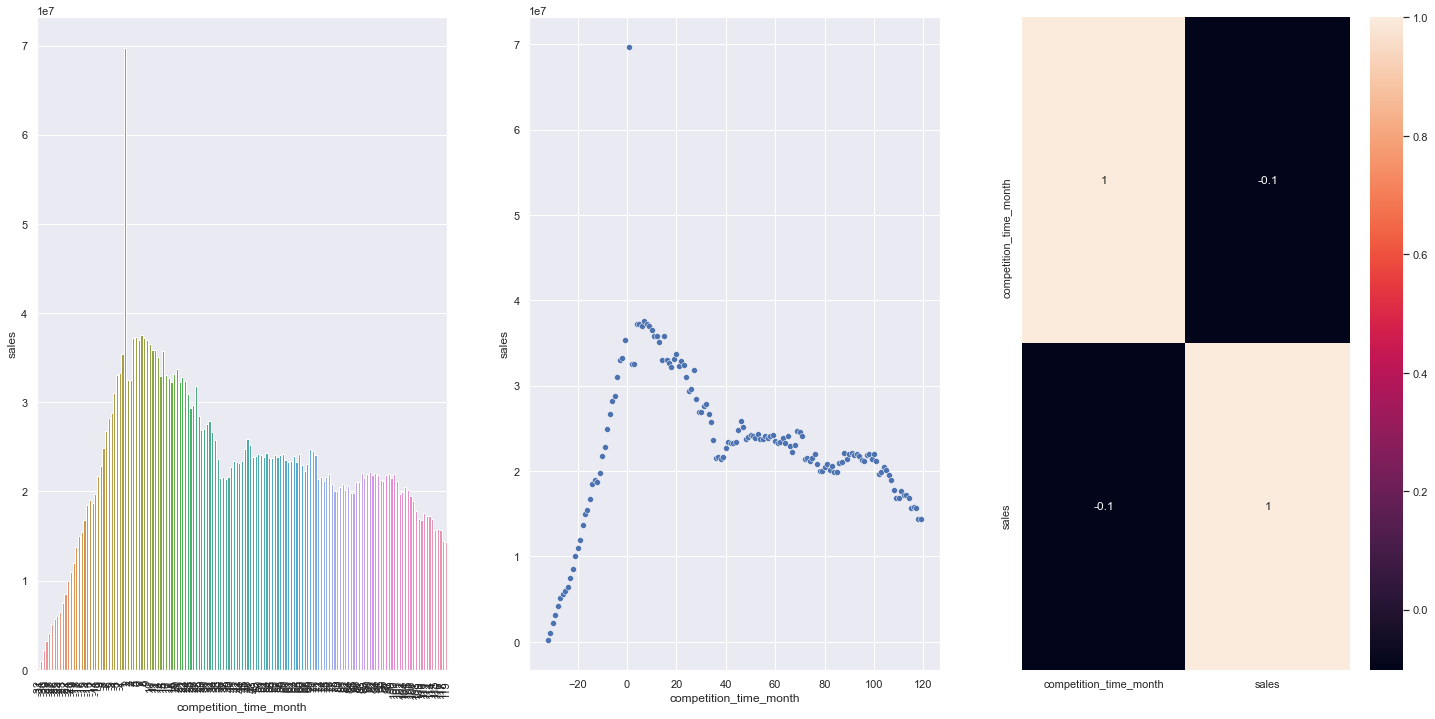

In [75]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month']<120 ) & ( aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

In [63]:
df4['competition_time_month'].value_counts()


 0       322626
 1        11494
 7         6404
 6         6309
 8         6254
 4         6250
 5         6246
 9         6155
 10        6154
 11        6022
 12        5923
 13        5787
 15        5703
 19        5667
 14        5660
 2         5658
 16        5651
 18        5581
-1         5580
 17        5570
 20        5569
 3         5557
 22        5510
 21        5420
 23        5398
-2         5370
-3         5272
 27        5118
 24        5109
 26        5063
 28        4955
 32        4921
 25        4908
-4         4860
 31        4857
 29        4782
 30        4715
-6         4677
-5         4650
 33        4599
 46        4452
 34        4420
 47        4360
-7         4332
 45        4315
 59        4267
 53        4260
 65        4252
 70        4243
 69        4212
 55        4201
 56        4199
 35        4199
 41        4192
 71        4191
 58        4179
 52        4175
 44        4170
 60        4160
 62        4159
 48        4146
 54        4144
 63     

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA** Lojas com promoces ativas por mais tempo vendem menos, depois de um certo periodo

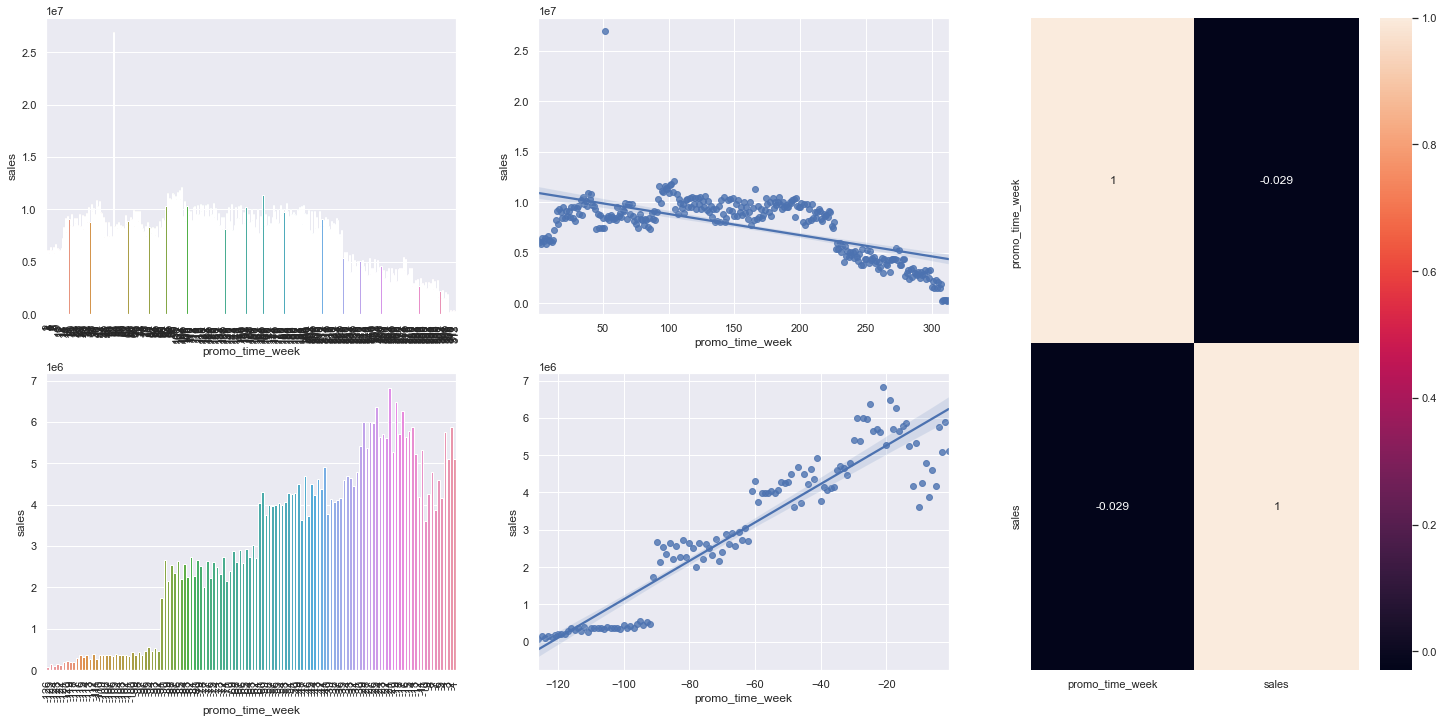

In [90]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0] #promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot(grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
                 
plt.subplot(grid[:,2])     
sns.heatmap( aux1.corr( method='pearson'), annot= True);

### H5. Lojas com promoções ativas por mais tempo deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais
***FALSA** Lojas com promoções consecutivas vendem menos

In [93]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


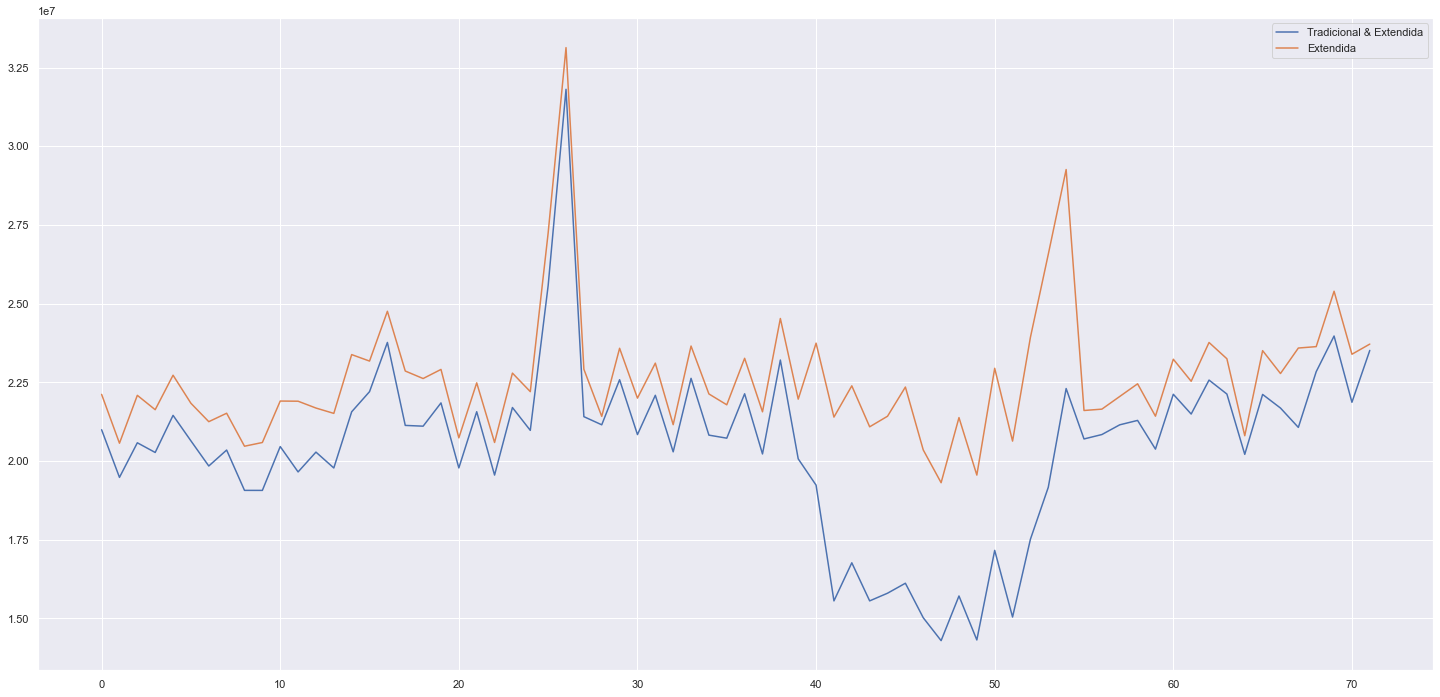

In [101]:
aux1 = df4[( df4['promo'] ==1 ) & ( df4['promo2']==1) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] ==1 ) & ( df4['promo2']==0) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas durante o feriado de natal deveriam vender mais.
***FALSA** Lojas com promoções consecutivas vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

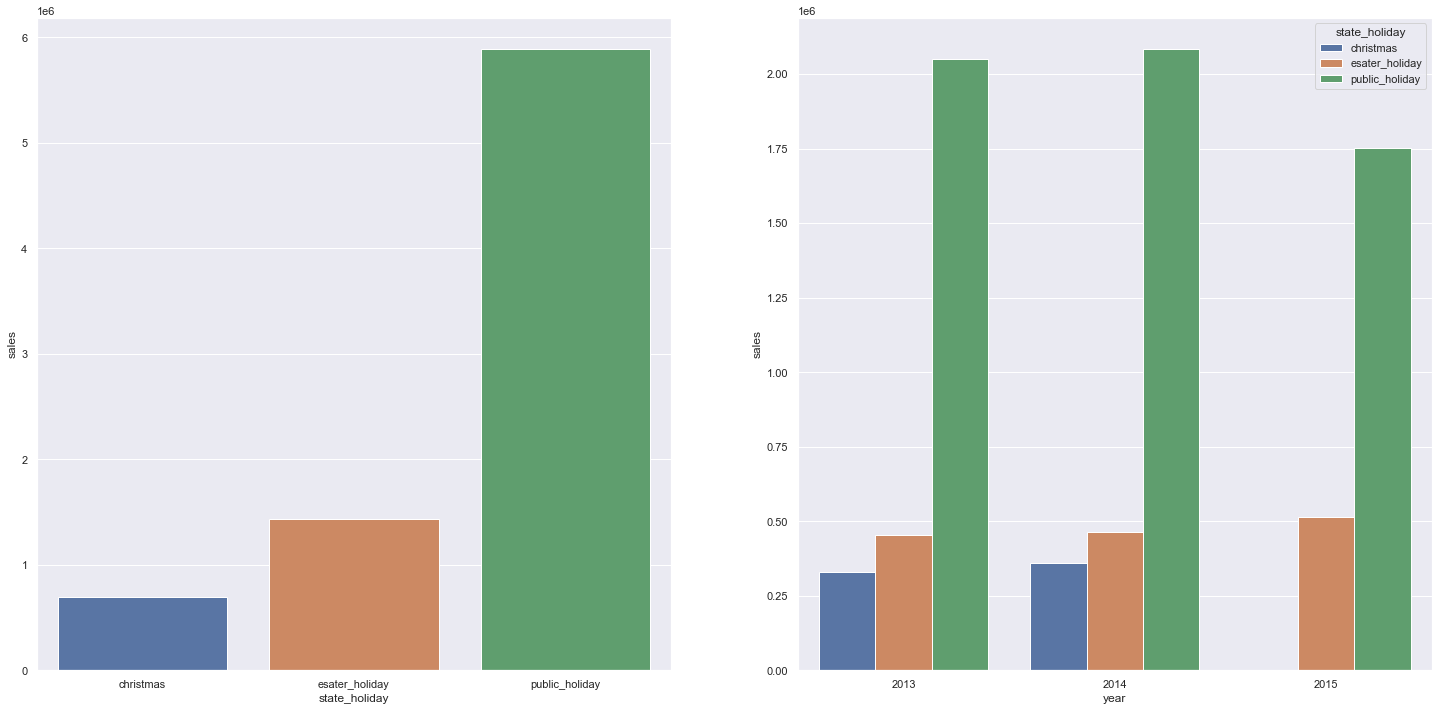

In [150]:
aux = df4[(df4['state_holiday'] != 'regular_day')]

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
          
plt.subplot(1, 2, 2) 
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
          

In [132]:
df4['state_holiday'].value_counts()

regular_day       986159
public_holiday     20260
esater_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

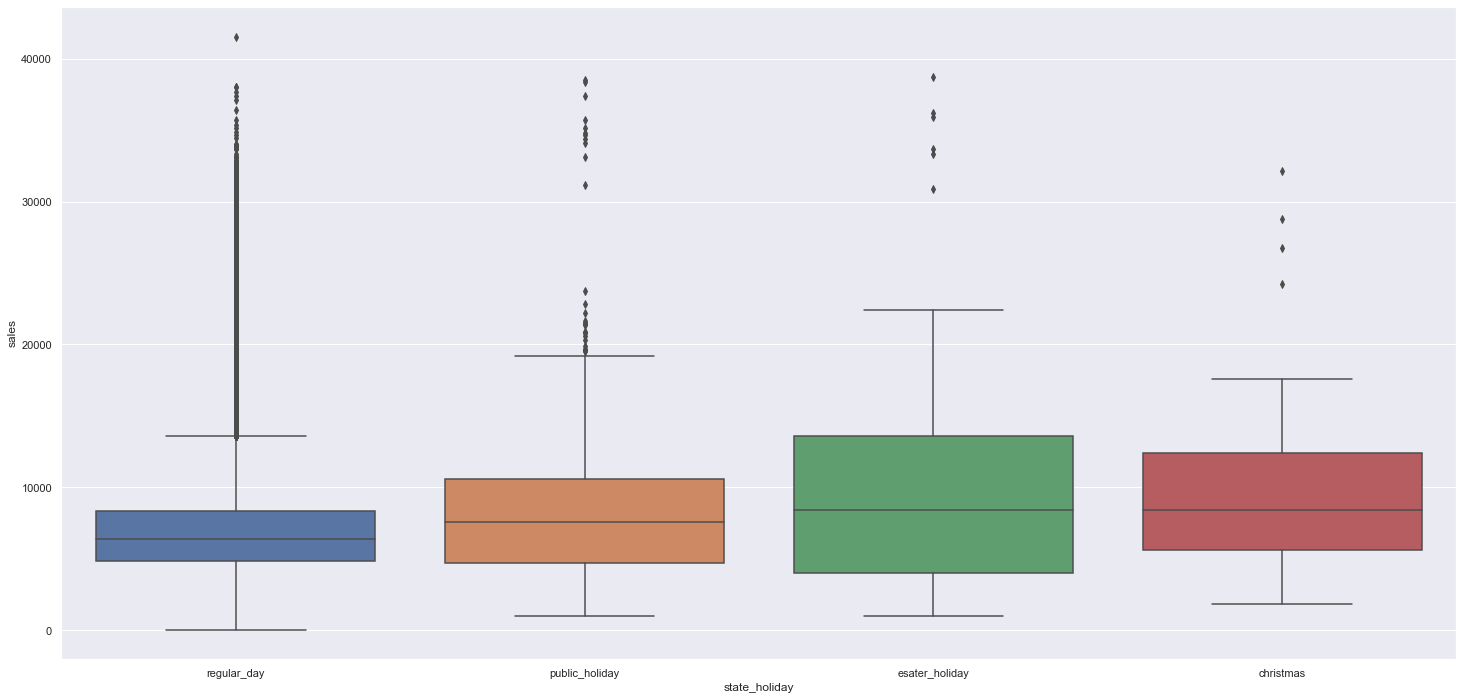

In [138]:
aux = df4[df4['sales']>0]
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.boxplot(x= 'state_holiday', y='sales', data=aux)

### H8. Lojas deveriam vender mais ao longo dos anos.


<AxesSubplot:xlabel='month', ylabel='sales'>

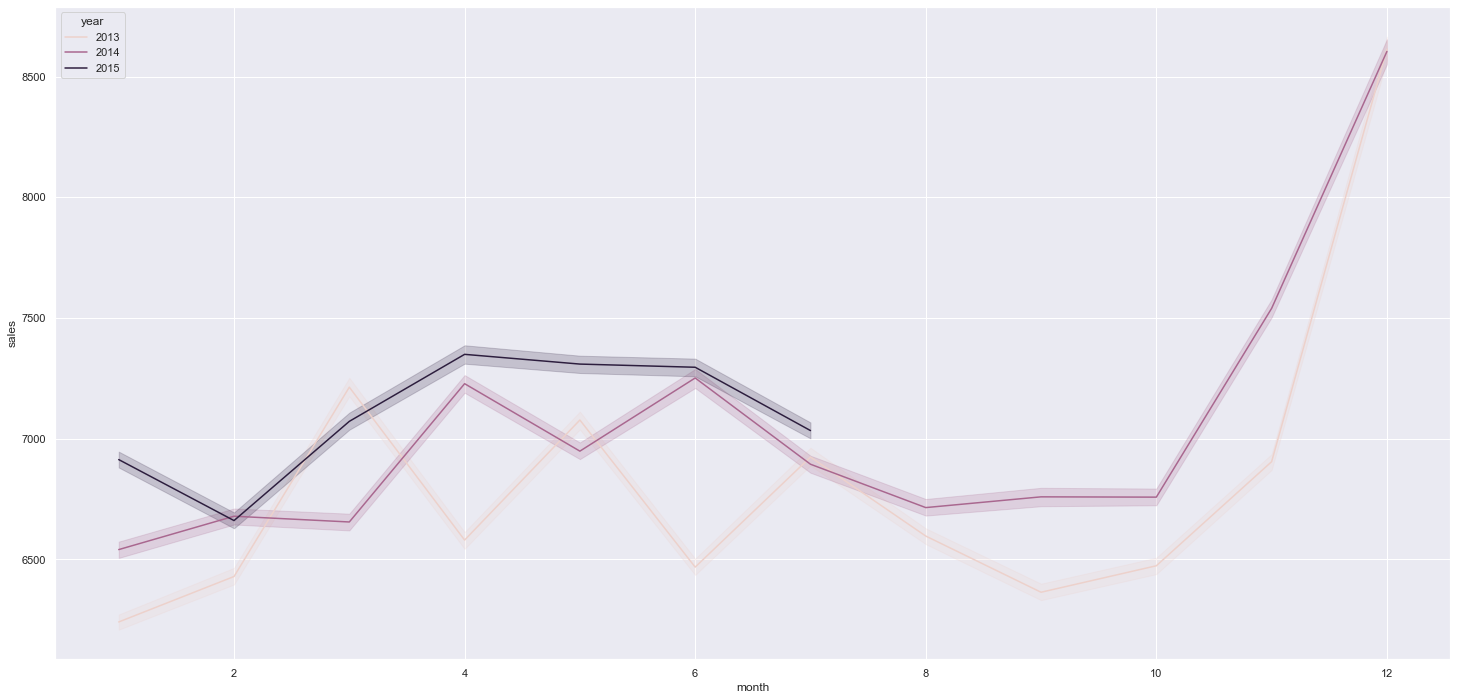

In [428]:
sns.lineplot(x=df4['month'], y=df4['sales'], hue='year', data=df4)

<AxesSubplot:xlabel='day', ylabel='sales'>

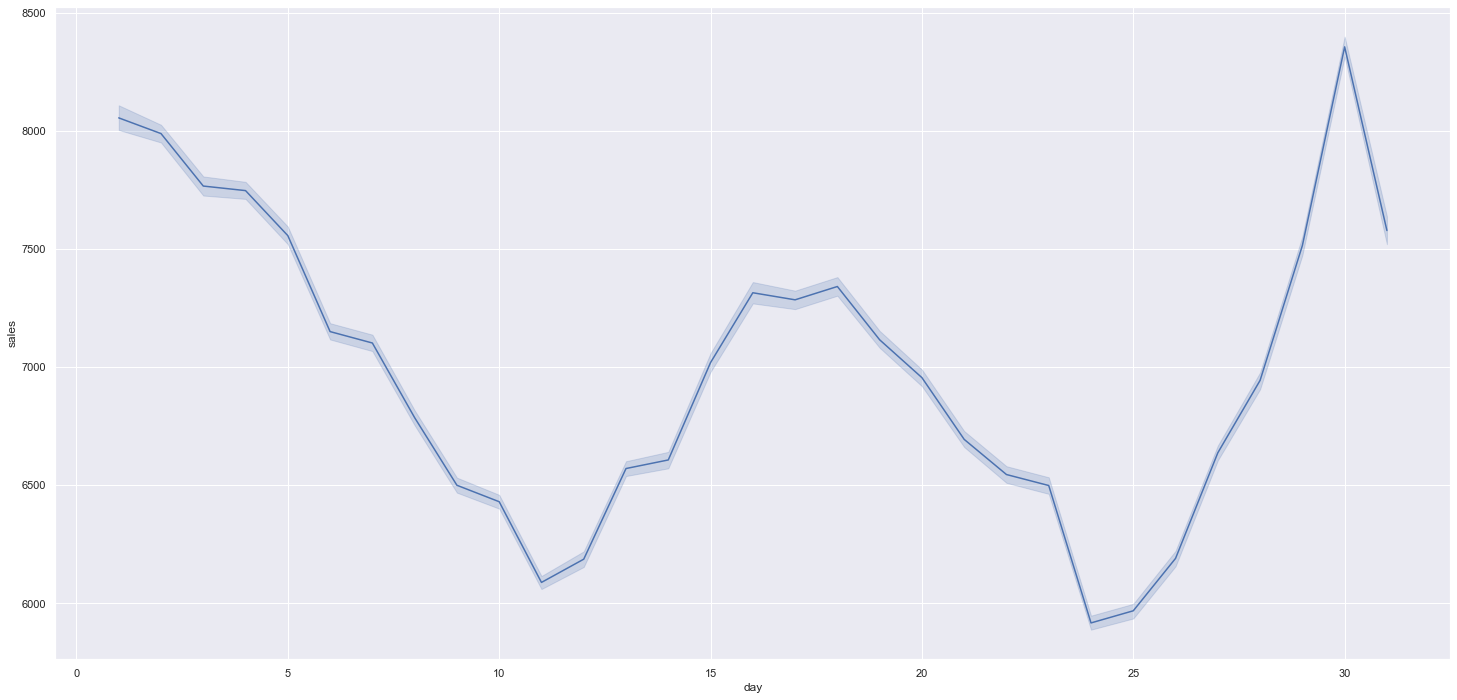

In [429]:
sns.lineplot(x=df4['day'], y=df4['sales'], data=df4)

### H9. Lojas deveriam vender mais no segundo semestre do ano.

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

### H11. Lojas deveriam vender menos aos finais de semana.

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

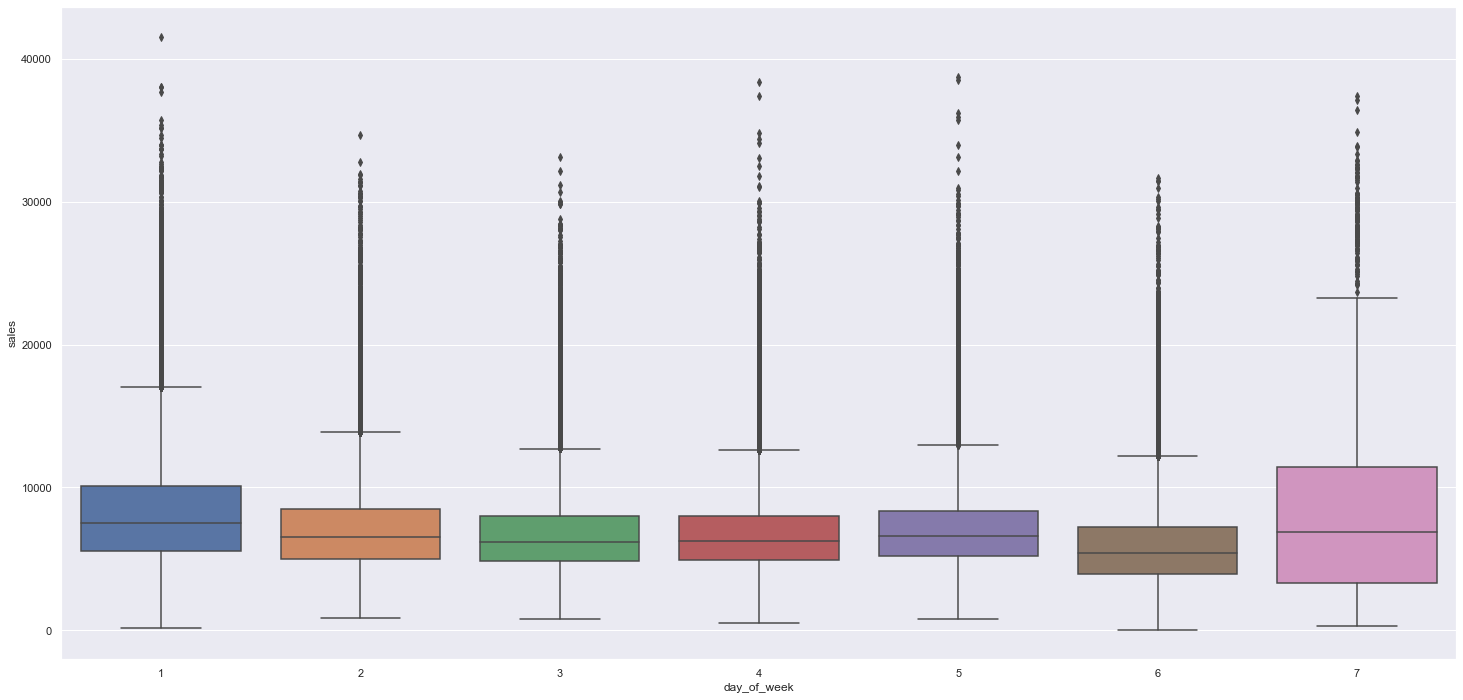

In [166]:
aux = df4[df4['sales']>0]
sns.boxplot(x=aux['day_of_week'], y=aux['sales'], data=aux)


In [171]:
aux = df2[df2['sales']==0]

In [173]:
aux.sample(100)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
162393,719,7,2015-03-08,0,0,0,0,regular_day,0,c,extended,8190.0,3,2015,1,45,2009,"Feb,May,Aug,Nov",Mar,0,2015,3,8,10,2015-09,2015-03-01,0,2009-11-02,278
746090,941,7,2013-09-01,0,0,0,0,regular_day,0,a,basic,1200.0,12,2011,1,31,2013,"Jan,Apr,Jul,Oct",Sep,0,2013,9,1,35,2013-34,2011-12-01,21,2013-07-29,4
146832,768,7,2015-03-22,0,0,0,0,regular_day,0,a,extended,2630.0,9,2012,0,12,2015,0,Mar,0,2015,3,22,12,2015-11,2012-09-01,31,2015-03-16,0
605374,715,7,2014-01-05,0,0,0,0,regular_day,0,a,basic,14810.0,6,2014,0,1,2014,0,Jan,0,2014,1,5,1,2014-00,2014-06-01,-5,2013-12-30,0
526660,51,7,2014-03-16,0,0,0,0,regular_day,0,a,extended,10570.0,7,2013,1,9,2011,"Jan,Apr,Jul,Oct",Mar,0,2014,3,16,11,2014-10,2013-07-01,8,2011-02-21,159
940373,99,7,2013-03-10,0,0,0,0,regular_day,0,c,extended,2030.0,11,2003,1,22,2012,"Mar,Jun,Sept,Dec",Mar,1,2013,3,10,10,2013-09,2003-11-01,113,2012-05-21,41
1003433,719,7,2013-01-13,0,0,0,0,regular_day,0,c,extended,8190.0,1,2013,1,45,2009,"Feb,May,Aug,Nov",Jan,0,2013,1,13,2,2013-01,2013-01-01,0,2009-11-02,166
278954,595,7,2014-11-16,0,0,0,0,regular_day,0,c,extended,1130.0,6,2015,0,46,2014,0,Nov,0,2014,11,16,46,2014-45,2015-06-01,-7,2014-11-10,0
162103,429,7,2015-03-08,0,0,0,0,regular_day,0,d,extended,16350.0,7,2005,1,31,2013,"Jan,Apr,Jul,Oct",Mar,0,2015,3,8,10,2015-09,2005-07-01,117,2013-07-29,83
925233,569,7,2013-03-24,0,0,0,0,regular_day,0,a,basic,1340.0,9,2006,0,12,2013,0,Mar,0,2013,3,24,12,2013-11,2006-09-01,79,2013-03-18,0


In [176]:
df2['open'].value_counts()

1    844392
0    172817
Name: open, dtype: int64

In [180]:
aux = df2[df2['open']==0]

In [183]:
aux['day_of_week'].value_counts()

7    141137
4     11201
5      7205
1      7170
3      3729
2      1703
6       672
Name: day_of_week, dtype: int64

### H12. Lojas deveriam vender menos durante os feriados escolares.

## 4.3. Analise Multivariada

# 5.0. Preparação dos Dados

In [98]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [227]:
a = df5.select_dtypes( include = ['int32', 'int64', 'float32', 'float64'])

In [214]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,0.905405,0.287016
1,2,5,6064,1,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,1.040541,0.922551
2,3,5,8314,1,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,1.189189,0.801822
3,4,5,13995,1,1,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,0.729730,0.287016
4,5,5,4822,1,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,-0.175676,0.287016


In [101]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

#competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

#promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )


## 5.3 Tranformação

### 5.3.1. Enconding

In [100]:
#state_holiday - One hot encoding

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

#assortment - Ordinal Econding

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [246]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_esater_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.905405,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.040541,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.189189,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.729730,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.175676,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable

In [35]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [36]:
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

In [37]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_esater_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984,0.5,-0.866025
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984,0.5,-0.866025
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984,0.5,-0.866025
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984,0.5,-0.866025
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984,0.5,-0.866025


# 6.0 Feature Selection

In [38]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [255]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_esater_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.905405,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,-2.449294e-16,0.207912,0.207912,-0.568065,-0.568065,0.5,0.5
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.040541,2010-03-22,0.922551,0,0,0,1,-2.449294e-16,-2.449294e-16,0.207912,0.207912,-0.568065,-0.568065,0.5,0.5
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.189189,2011-03-28,0.801822,0,0,0,1,-2.449294e-16,-2.449294e-16,0.207912,0.207912,-0.568065,-0.568065,0.5,0.5
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.729730,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,-2.449294e-16,0.207912,0.207912,-0.568065,-0.568065,0.5,0.5
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.175676,2015-07-27,0.287016,0,0,0,1,-2.449294e-16,-2.449294e-16,0.207912,0.207912,-0.568065,-0.568065,0.5,0.5


In [39]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1)

In [40]:
 df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [41]:
#training dataser

X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test dataset

X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print( 'Traning Min Date: {}'.format( X_train['date'].min() ) )
print( 'Traning Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [277]:
#training and test dataset for boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
Y_train_n = Y_train.values.ravel()


# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1)

#define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	14
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	1
Reject

### 6.2.1 Best Feature from Boruta

In [278]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [279]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2_since_week',
 'competition_time_month',
 'promo_time_week',
 'state_holiday_regular_day',
 'day_of_week_sin',
 'day_of_week_cos']

In [280]:
cols_not_selected_boruta

['assortment',
 'day_cos',
 'day_sin',
 'is_promo',
 'month_cos',
 'month_sin',
 'promo2',
 'promo2_since_year',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_esater_holiday',
 'state_holiday_public_holiday',
 'week_of_year_cos',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [42]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin', ]

#colums to add

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


In [43]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0. MACHINE LEARNING MODELLING

In [44]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [45]:
x_train.shape

(802942, 20)

In [46]:
x_test.shape

(41396, 20)

## 7.1 Average Model

In [47]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )

aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Avarage Model', np.expm1(Y_test), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [48]:
#model
lr = LinearRegression().fit( x_train, Y_train )

#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.961284,0.291737,2664.881612


### 7.2.1. Linear Regression Model - Cross Validation

In [49]:
x_training = X_train[ cols_selected_boruta_full ]

lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)

In [50]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2044.05+/-261.84,0.3+/-0.01,2905.12+/-391.24


## 7.3 Linear Regression Regularized Model - Lasso

In [439]:
#model
lrr = Lasso(alpha=0.01).fit( x_train, Y_train )

#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1920.582381,0.296545,2769.606965


### 7.3.1 Lasso - Cross Validation

In [503]:
x_training = X_train[ cols_selected_boruta_full ]

lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)

In [505]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2131.42+/-324.65,0.3+/-0.01,3070.43+/-474.25


## 7.4 Random Forest Regressor

In [440]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs=-1, random_state=42 ).fit( x_train, Y_train )

#prediction
yhat_rf = rf.predict( x_test)

#performance

rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test), np.expm1( yhat_rf))
rf_result

NameError: name 'y_test' is not defined

In [442]:
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.620139,0.098671,1039.981728


### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
x_training = X_train[ cols_selected_boruta_full ]

rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)

In [ ]:
rf_result_cv

## 7.5 XGBoost Regressor

In [52]:
# model
model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
                             n_estimators = 100, 
                             eta=0.01,
                             max_depth = 10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, Y_train )

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance

xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test), np.expm1( yhat_xgb))
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,872.018834,0.126451,1270.744191


### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
x_training = X_train[ cols_selected_boruta_full ]
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',xgb, verbose=True)

In [ ]:
xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Compare Model's Performance

In [443]:
modelling_result = pd.concat([ baseline_result,lr_result, lrr_result, rf_result, xgb_result ])
modelling_result.sort_values ( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.620139,0.098671,1039.981728
0,Avarage Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1895.028745,0.298276,2707.083052
0,Linear Regression - Lasso,1920.582381,0.296545,2769.606965


### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ])
modelling_result_cv.sort_values ( 'RMSE' )

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Seach

In [53]:
import random

In [54]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
            }
MAX_EVAL = 10          

In [56]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    #choose values for parameters randonly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
    print( hp )
    # model
    model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample= hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )


    #performance

    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose= False)
    final_result = pd.concat( [final_result, result])

final_result

{'n_estimators': 30, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 30, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2929.77+/-83.24,0.34+/-0.0,3931.78+/-136.82
0,XGBoost Regressor,2929.77+/-83.24,0.34+/-0.0,3931.78+/-136.82


## 8.2 Final Model

In [69]:
param_tuned = {
        'n_estimators': 3000 ,
        'eta': 0.03 ,
        'max_depth': 5 ,
        'subsample': 0.7,
        'colsample_bytree': 0.7 ,
        'min_child_weight': 3
            } 

In [70]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective= 'reg:squarederror',
                                 n_estimators = param_tuned['n_estimators'],
                                 eta=param_tuned['eta'],
                                 max_depth = param_tuned['max_depth'],
                                 subsample= param_tuned['subsample'],
                                 colsample_bytree=param_tuned['colsample_bytree'],
                                 min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, Y_train)

#prediction
    
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

#performance

xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.453479,0.096067,956.720944


# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

In [73]:
df9 = X_test[ cols_selected_boruta_full ]

#reacale

df9['sales'] = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [82]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

#MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

#Merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92= pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order colums

df92 = df92[[ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]



In [76]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104284.351562,101003.501876,107565.201249,3280.849686,0.543164
908,909,247413.890625,239817.582732,255010.198518,7596.307893,0.528489
875,876,199298.906250,195179.786366,203418.026134,4119.119884,0.307441
721,722,350780.218750,348848.212904,352712.224596,1932.005846,0.260059
273,274,193146.312500,191708.657346,194583.967654,1437.655154,0.252606


<AxesSubplot:xlabel='store', ylabel='MAPE'>

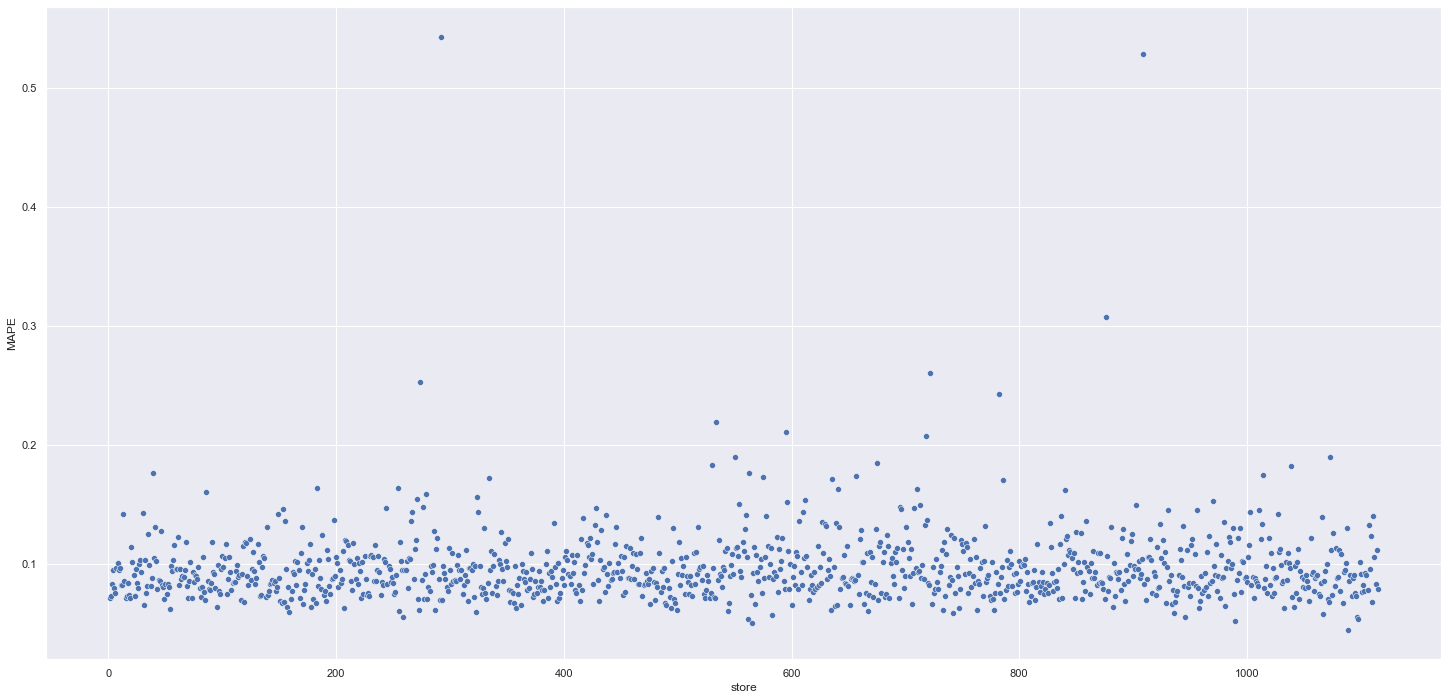

In [77]:
sns.scatterplot(x='store', y='MAPE', data = df92)

## 9.2. Total Performance

In [86]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ),axis = 0).reset_index().rename( columns={'index': 'Scenarios', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenarios,Values
0,predictions,"R$284,911,200.00"
1,worst_scenario,"R$284,171,854.98"
2,best_scenario,"R$285,650,549.71"


## 9.3. Machine Learning Performance 

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

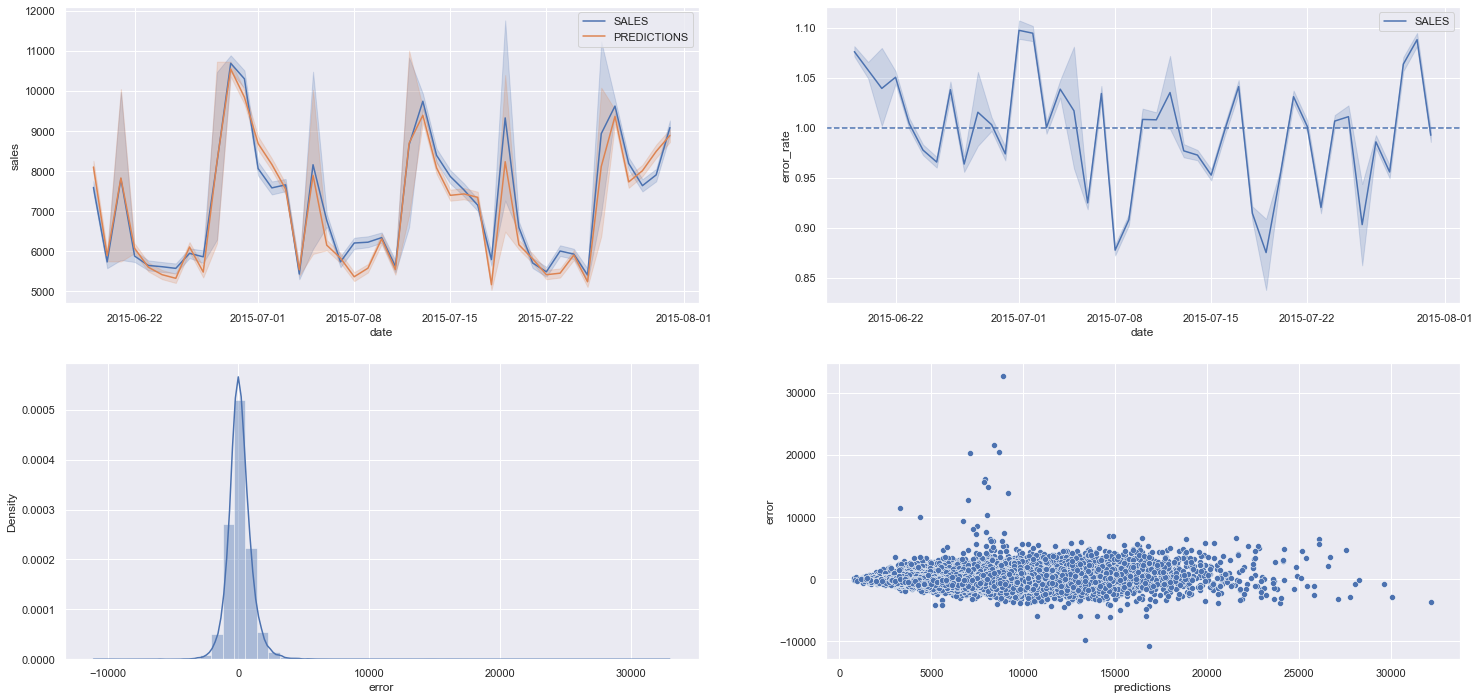

In [92]:
plt.subplot( 2, 2, 1)

sns.lineplot( x='date', y='sales', data=df9, label = 'SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label = 'PREDICTIONS' )

plt.subplot( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9, label = 'SALES' )
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot( df9['error'] )

plt.subplot(2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'] )


# 10.0. DEPLOY MODEL TO PRODUCTION

In [95]:
# Save Trained Model

pickle.dump( model_xgb_tuned, open( '/Users/Caetano/repos/Predict-Time-Series/model/model_rossmann.pkl', 'wb') )

## 10.1. Rossmann Class

In [32]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        
        self.home_path='/Users/Caetano/repos/Predict-Time-Series/'
        self.competition_distance_scaler    = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler  = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.promo_time_week_scaler         = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.year_scaler                    = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler              = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )    
            
    def data_cleaning ( self, df1 ):
        
        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
                   'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                   'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new


        ## 1.3. Data Types

        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5 Fillout NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis =1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis =1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis =1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

        df1['promo_interval'].fillna( 0, inplace = True )

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2):
        
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days).astype( int )

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))

        df2 ['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment

        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended' )

        # state holiday

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x== 'a' else 'esater_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas

        df2 = df2[(df2['open']!= 0)]

        ## 3.2. Selecao das Colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    
    def data_preparation( self, df5 ):
        
        ##5.2. Rescaling
        # competition distance
        
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)


        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)
        

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
       
   
        #year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        ### 5.3.1. Enconding

        #state_holiday - One hot encoding

        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding

        #le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )


        #assortment - Ordinal Econding

        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)



        ### 5.3.3. Nature Transformation

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )
       
        cols_selected = [
         'store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'competition_time_month',
         'promo_time_week',
         'day_of_week_sin',
         'day_of_week_cos',
         'month_sin',
         'month_cos',
         'day_sin',
         'day_cos',
         'week_of_year_cos',
         'week_of_year_sin', ]

                                                                  
                                                                  
        return df5[ cols_selected ]
                                                                  
    def get_prediction( self, model, original_data, test_data ):
        print("entrei get prediction")
        #prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['Prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
        

## 10.2. API Handler

In [29]:
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann
import json


#loading model
pickle.load( open( '/Users/Caetano/repos/Predict-Time-Series/model/model_rossmann.pkl', 'rb') )


app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data 
        if isinstance( test_jon, dict): #unique Example
            test_raw = pd.DataFrame( test_json, index[0] )
        
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2 )
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw. df3)
        
        return df_response
    
    else:
        return Responde( '{}', status=200, mimetype='application/json' )
        
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [6]:
import requests

In [13]:
import json

In [72]:
df10 = pd.read_csv( '/Users/Caetano/repos/Predict-Time-Series/data/test.csv' )

In [73]:
#merge test dataset + store_raw

df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

#choose store for prediction

df_test = df_test[df_test['Store'].isin( [20,22,23] )]

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [74]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
13,20,4,2015-09-17,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
16,23,4,2015-09-17,1.0,1,0,0,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN
869,20,3,2015-09-16,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [79]:
# convert Dataframe to json

data = json.dumps( df_test.to_dict( orient = 'records' ) )



In [80]:
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 23, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 4060.0, "CompetitionOpenSinceMonth": 8.0, "CompetitionOpenSinceYear": 2005.0, "Promo2": 0, "Promo2SinceWeek

In [88]:
# API Call

#url = 'http://localhost:5000/rossmann/predict/'
url = 'https://rossmann-model1.herokuapp.com/rossmann/predict/'


header ={'Content-type': 'application/json'} 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status code {}'.format( r.status_code ) )

Status code 200


In [82]:
d1 = pd.DataFrame( r.json(), columns =r.json()[0].keys() )

In [83]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,Prediction
0,20,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,8132.999512
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3321.132568
2,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,8,2005,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,6637.396973
3,20,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,8109.846191
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,3208.479248


In [58]:
d2 = d1[['store', 'Prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 )):
    print( 'Store Number {} will sell {} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'Prediction'] ) )

Store Number 12 will sell 208523.7070312499 in the next 6 weeks
Store Number 22 will sell 147247.4200439451 in the next 6 weeks
Store Number 24 will sell 255174.47290039048 in the next 6 weeks
